In [1]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

In [7]:
# Read in the volume and get the isocenter
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# Initialize the DRR module for generating synthetic X-rays
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
help(DRR)

cpu
Help on class DRR in module diffdrr.drr:

class DRR(torch.nn.modules.module.Module)
 |  DRR(volume: 'np.ndarray', spacing: 'np.ndarray', sdr: 'float', height: 'int', delx: 'float', width: 'int | None' = None, dely: 'float | None' = None, p_subsample: 'float | None' = None, reshape: 'bool' = True, reverse_x_axis: 'bool' = False, patch_size: 'int | None' = None)
 |  
 |  PyTorch module that computes differentiable digitally reconstructed radiographs.
 |  
 |  Method resolution order:
 |      DRR
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, volume: 'np.ndarray', spacing: 'np.ndarray', sdr: 'float', height: 'int', delx: 'float', width: 'int | None' = None, dely: 'float | None' = None, p_subsample: 'float | None' = None, reshape: 'bool' = True, reverse_x_axis: 'bool' = False, patch_size: 'int | None' = None)
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self:

In [10]:
"""drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=800,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.0,    # Pixel spacing (in mm)
).to(device)
"""
drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=1000.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

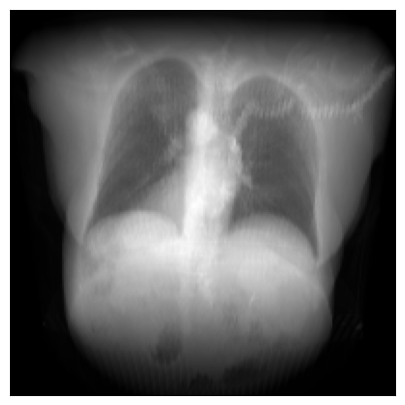

In [15]:
# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
rotation = torch.tensor([[0.0, 2*torch.pi/10 , torch.pi / 2]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

0.0


<Figure size 640x480 with 0 Axes>

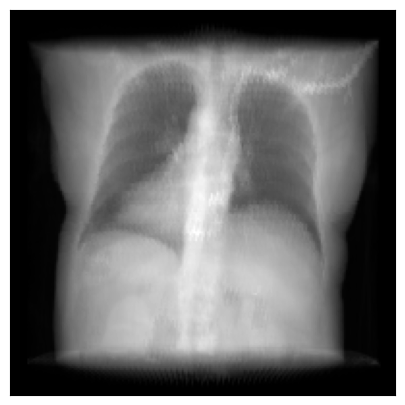

0.3141592653589793


<Figure size 640x480 with 0 Axes>

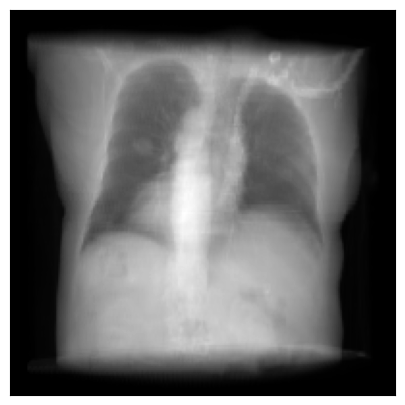

0.6283185307179586


<Figure size 640x480 with 0 Axes>

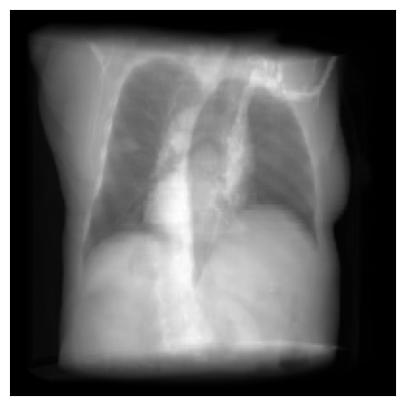

0.9424777960769379


<Figure size 640x480 with 0 Axes>

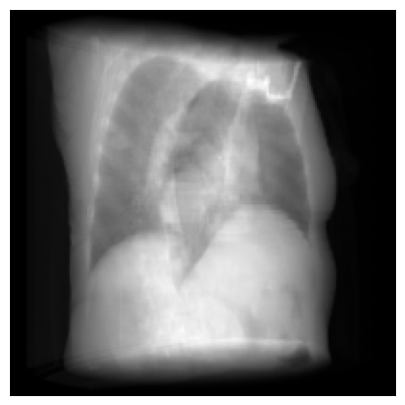

1.2566370614359172


<Figure size 640x480 with 0 Axes>

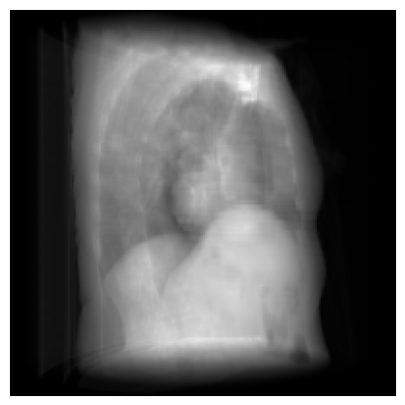

1.5707963267948966


<Figure size 640x480 with 0 Axes>

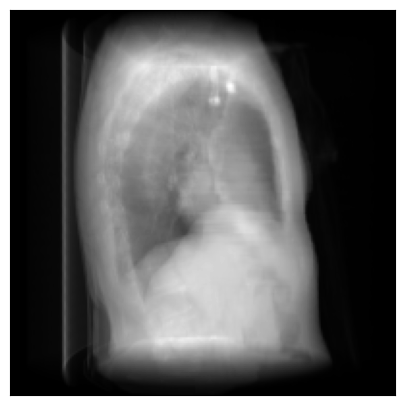

1.8849555921538759


<Figure size 640x480 with 0 Axes>

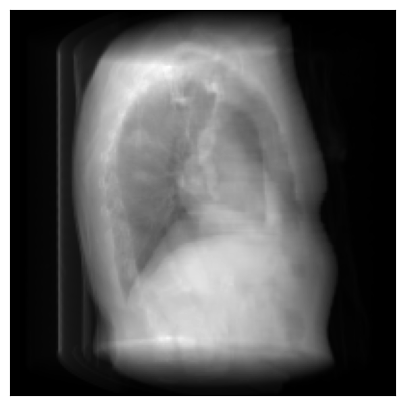

2.199114857512855


<Figure size 640x480 with 0 Axes>

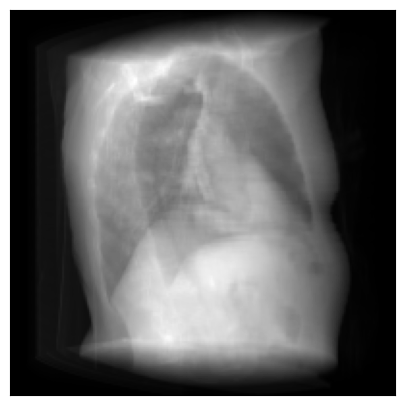

2.5132741228718345


<Figure size 640x480 with 0 Axes>

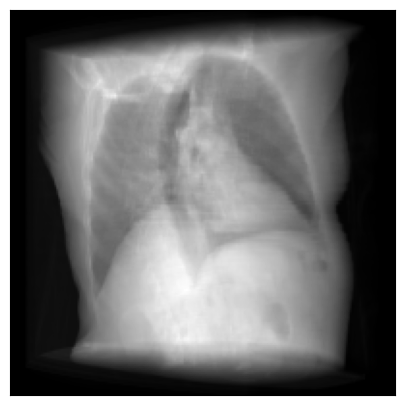

2.827433388230814


<Figure size 640x480 with 0 Axes>

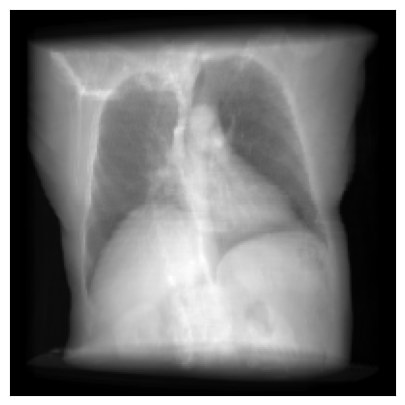

3.141592653589793


<Figure size 640x480 with 0 Axes>

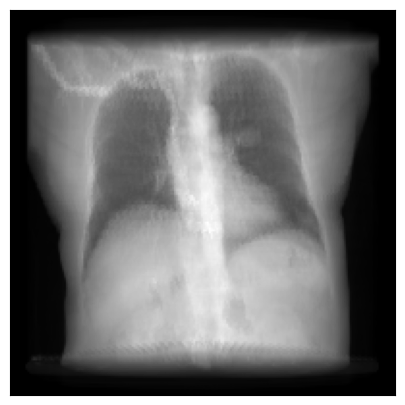

3.455751918948772


<Figure size 640x480 with 0 Axes>

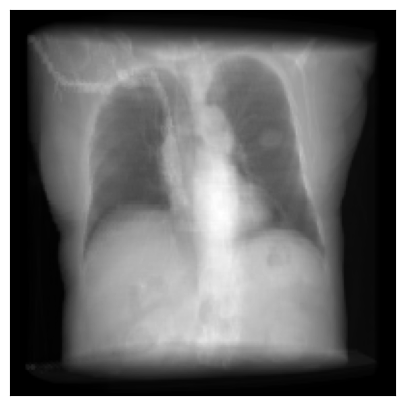

3.7699111843077517


<Figure size 640x480 with 0 Axes>

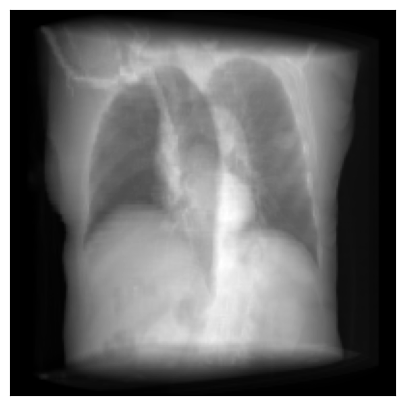

4.084070449666731


<Figure size 640x480 with 0 Axes>

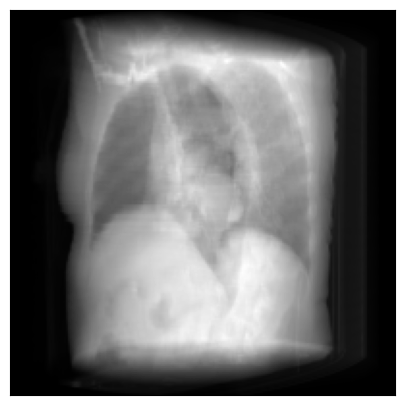

4.39822971502571


<Figure size 640x480 with 0 Axes>

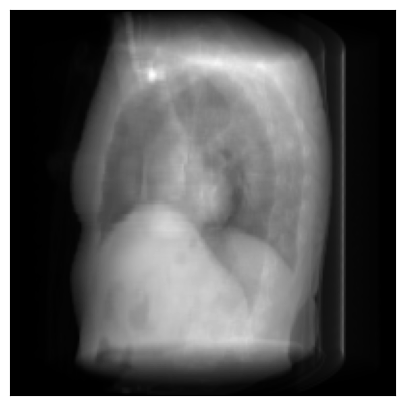

4.71238898038469


<Figure size 640x480 with 0 Axes>

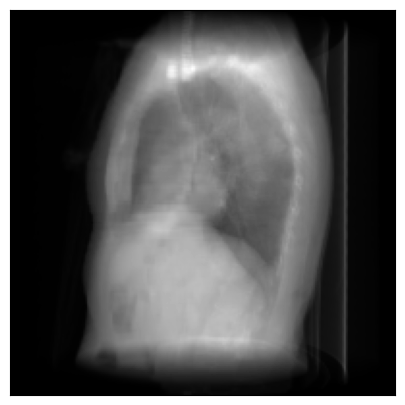

5.026548245743669


<Figure size 640x480 with 0 Axes>

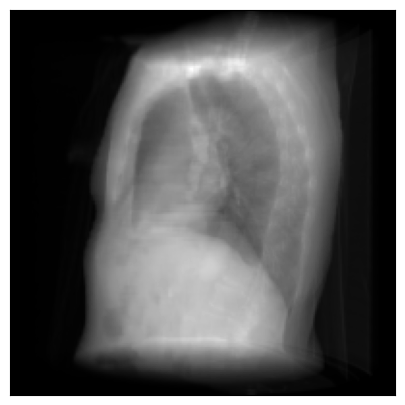

5.340707511102648


<Figure size 640x480 with 0 Axes>

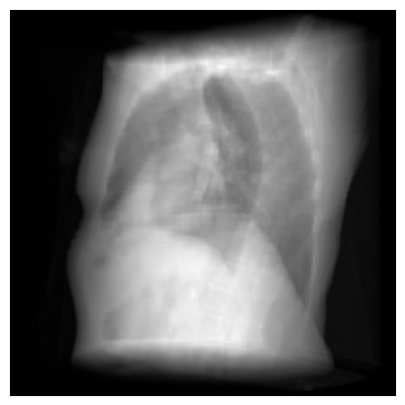

5.654866776461628


<Figure size 640x480 with 0 Axes>

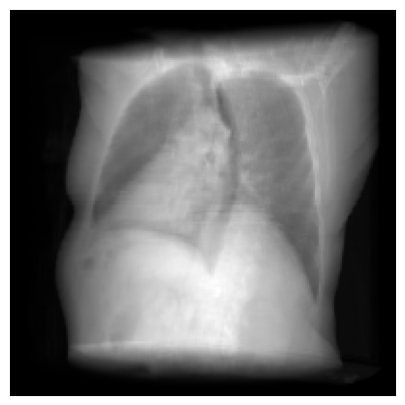

5.969026041820607


<Figure size 640x480 with 0 Axes>

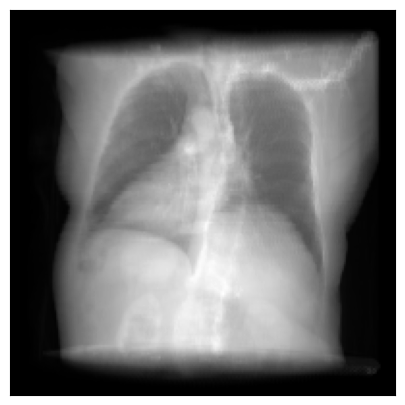

In [21]:
N_views = 20
for idx_x in range(N_views):
    rad_x = idx_x*2*torch.pi/N_views
    print(rad_x)
    rotation = torch.tensor([[rad_x, 0.0 , torch.pi / 2]], device=device)
    translation = torch.tensor([[bx, by, bz]], device=device)

    # 📸 Also note that DiffDRR can take many representations of SO(3) 📸
    # For example, quaternions, rotation matrix, axis-angle, etc...
    img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
    plt.figure()
    plot_drr(img, ticks=False)
    plt.show()

### Read XML files
Follow instructions at:

https://pylidc.github.io/

In [22]:
import pylidc as pl

ModuleNotFoundError: No module named 'pylidc'